## Input data format

Eradiate represents DEM data as triangulated meshes. The easiest and preferred way to provide DEM data to Eradiate is therefore a prepared triangulated mesh in PLY-format.

Eradiate does not parse metadata associated with the PLY-format and therefore will not perform any unit conversions on the data. Vertex position data will be interpreted as kernel-units and the meaning of the x and y dimensions will depend on the scene geometry.

For example the default case, the plane parallel geometry and default kernel units, mean that positions will be interpreted as meters and the X, Y, and Z dimensions will map to EAST, NORTH, and UP (ENU).

The rest of this tutorial will assume that DEM data in ply format is available. In this tutorial we will use a 20 km by 20 km section near the Libya4 CEOS site. (Note for reviewer: Is this the right name?) If this file is not present on your machine, it can be downloaded from (add a link) and must be placed in the (add) subfolder.

## Imports

First we import all the necessary components for this tutorial

In [2]:
import eradiate

eradiate.set_mode("mono")

from eradiate.units import unit_registry as ureg

import matplotlib.pyplot as plt
import numpy as np

## Declaring scene elements

Now we declare the scene elements that are independent of the DEM. That is, illumination, sensor and atmosphere.
In this first part of the tutorial we will compute the BRF of the scene first without and then with an atmosphere. We will limit the observation to the principal plane.
We will attach a Lamberitian BSDF to all surfaces in this tutorial, to visualize the effect of the 3D terrain on the BRF.

In [60]:
illumination = eradiate.scenes.illumination.DirectionalIllumination(zenith=45, azimuth=0)

sensor = eradiate.scenes.measure.MultiDistantMeasure.hplane(
    azimuth=0,
    zeniths=np.arange(-60, 61, 2),
    srf={"type": "multi_delta", "wavelengths": [550.0] * ureg.nm},
    target=eradiate.scenes.measure.TargetRectangle(
        xmin=-10*ureg.km,
        xmax=10*ureg.km,
        ymin=-10*ureg.km,
        ymax=10*ureg.km,
        z=130*ureg.m
    ),
)

camera_oblique = eradiate.scenes.measure.PerspectiveCameraMeasure(
    origin=[300, 300, 300]*ureg.km,
    target=[0, 0, 0]*ureg.km,
    up=[0, 0, 1],
    film_resolution=[128, 128],
    srf={"type": "multi_delta", "wavelengths": [550.0] * ureg.nm},
    fov=170,
)

atmosphere = eradiate.scenes.atmosphere.HeterogeneousAtmosphere(
    molecular_atmosphere=eradiate.scenes.atmosphere.MolecularAtmosphere(),
    particle_layers=[
        eradiate.scenes.atmosphere.ParticleLayer(
            bottom=0*ureg.m,
            top=2*ureg.km,  # add the other parameters
        )
    ]
)

flat_surface = eradiate.scenes.bsdfs.LambertianBSDF(reflectance=0.5)

Now we visualize the basic scene we have created

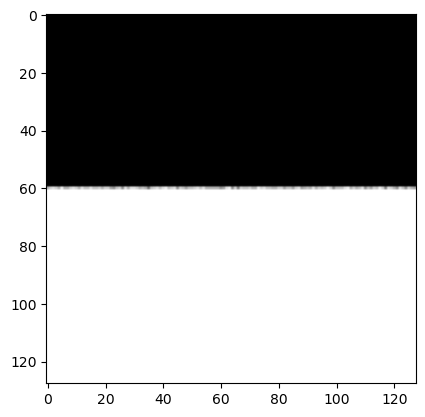

In [64]:
exp = eradiate.experiments.AtmosphereExperiment(
    illumination=illumination,
    measures=camera_oblique,
    surface=flat_surface,
    atmosphere=None
)

result = eradiate.run(exp, spp=16)
plt.imshow(result.radiance.squeeze(), cmap="gray")

A flat surface with Lamberitan reflectance and no atmosphere. Not very interesting, but as expected. Now we add the DEM mesh. We achive this by using Eradiate's expert interface.

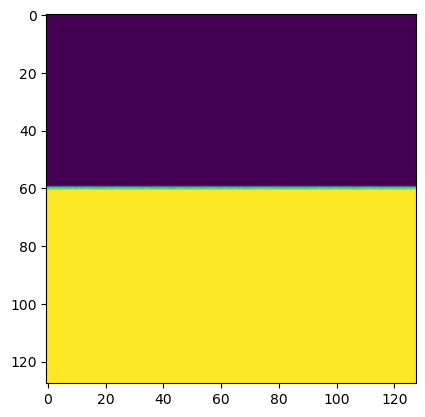